importing needed libraries/modules

In [92]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from joblib import dump

loading data

In [2]:
app = pd.read_csv(r"C:\Users\dimas\OneDrive\Studying Data\archive (2)\application_record.csv")
cc = pd.read_csv(r"C:\Users\dimas\OneDrive\Studying Data\archive (2)\credit_record.csv")

In [3]:
app.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
dtype: object

changing datatypes and making columns more sutitable for wrangling(dataset is relatively small and oerations differ so i have decided it to be more suitable approach than scripting

In [4]:
mapping = {"Y": True, "N": False}
app['ID']=app['ID'].astype('category')
app['CAR_OWN']=app['FLAG_OWN_CAR'].replace(mapping).astype('bool')
app['REALTY_OWN']=app['FLAG_OWN_REALTY'].replace(mapping).astype('bool')
app['GENDER']=app['CODE_GENDER'].astype('category')
app['CHILD_NUM']=app['CNT_CHILDREN'].astype('int32')
app['FAM_NUM']=app['CNT_FAM_MEMBERS'].astype('int32')
app['INCOME_TYPE']=app['NAME_INCOME_TYPE'].astype('category')
app['EDU_LEVEL'] = app['NAME_EDUCATION_TYPE'].astype('category')
app['FAM_ST']=app['NAME_FAMILY_STATUS'].astype('category')
app['HOUSING_TYPE']=app['NAME_HOUSING_TYPE'].astype('category')
app['AGE']=app['DAYS_BIRTH']*(-1)*(1/365)
app.loc[app['DAYS_EMPLOYED']>0,'DAYS_EMPLOYED']=0
app['EMP_LEN']=app['DAYS_EMPLOYED']*(-1)*(1/365)
app['MOB_PHONE']=app['FLAG_MOBIL'].astype('bool')
app['WORK_PHONE']=app['FLAG_WORK_PHONE'].astype('bool')
app['EMAIL']=app['FLAG_EMAIL'].astype('bool')
app['OCC_TYPE']=app['OCCUPATION_TYPE'].astype('category')
mapping_gender = {"M": True, "F": False}
app['IS_MALE']=app['CODE_GENDER'].replace(mapping_gender).astype('bool')
old_col = ['FLAG_OWN_REALTY','FLAG_OWN_CAR','CNT_FAM_MEMBERS','CNT_CHILDREN','NAME_INCOME_TYPE',
           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','DAYS_BIRTH',
           'DAYS_EMPLOYED','FLAG_MOBIL','FLAG_WORK_PHONE','FLAG_EMAIL','OCCUPATION_TYPE','CODE_GENDER','MOB_PHONE','FLAG_PHONE','OCC_TYPE']
app = app.drop(old_col,axis=1)
cc['ID']=cc['ID'].astype('category')
mapping_gender = {"M": True, "F": False}
app['IS_MALE']=app['GENDER'].replace(mapping_gender).astype('bool')

merging two datasets

In [5]:
credit = app.merge(cc,how='inner',on=['ID'])

figuring out correlations

<AxesSubplot:>

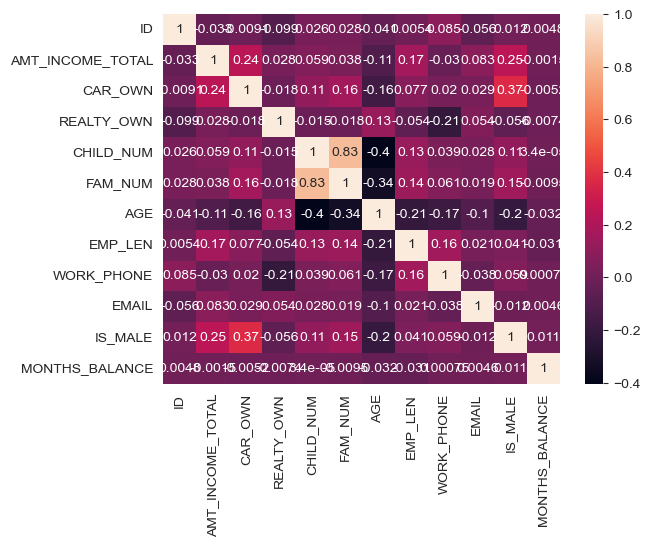

In [6]:
sns.heatmap(credit.corr(method='spearman'),annot=True)

checking for redundance(there was not,but a restriction was discovered on the way)

<AxesSubplot:xlabel='CHILD_NUM', ylabel='FAM_NUM'>

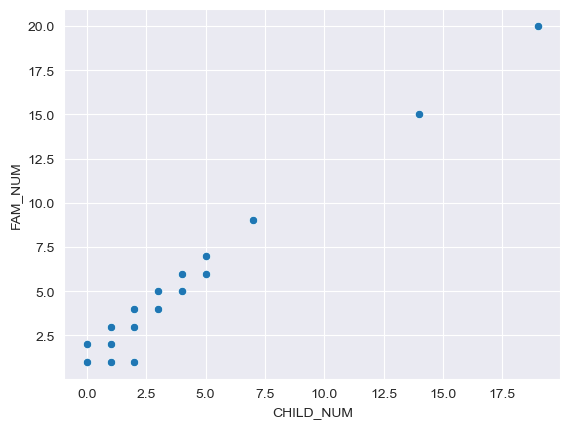

In [7]:
sns.scatterplot(data=credit,y='FAM_NUM',x='CHILD_NUM')

In [8]:
print(len(credit.loc[(credit['CHILD_NUM']/credit['FAM_NUM'])>1]),(credit['CHILD_NUM']/credit['FAM_NUM']).describe(),len(credit.loc[credit['CHILD_NUM']>8,'CHILD_NUM']))

67 count    777715.000000
mean          0.127101
std           0.200159
min           0.000000
25%           0.000000
50%           0.000000
75%           0.333333
max           2.000000
dtype: float64 117


applying the restriction and finding out that was not covered multicolinearity

<AxesSubplot:>

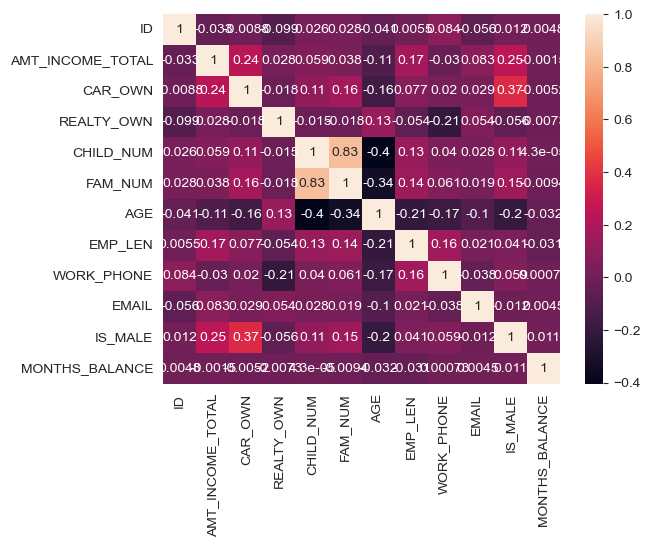

In [9]:
credit = credit.loc[((credit['CHILD_NUM']/credit['FAM_NUM'])<1)&(credit['CHILD_NUM']<8)]
sns.heatmap(credit.corr(method='spearman'),annot=True)

visualizing relations overall(turns out data is pretty clean with a little to no outliers,some of which occured to be valid data points(high-level clients mostly)

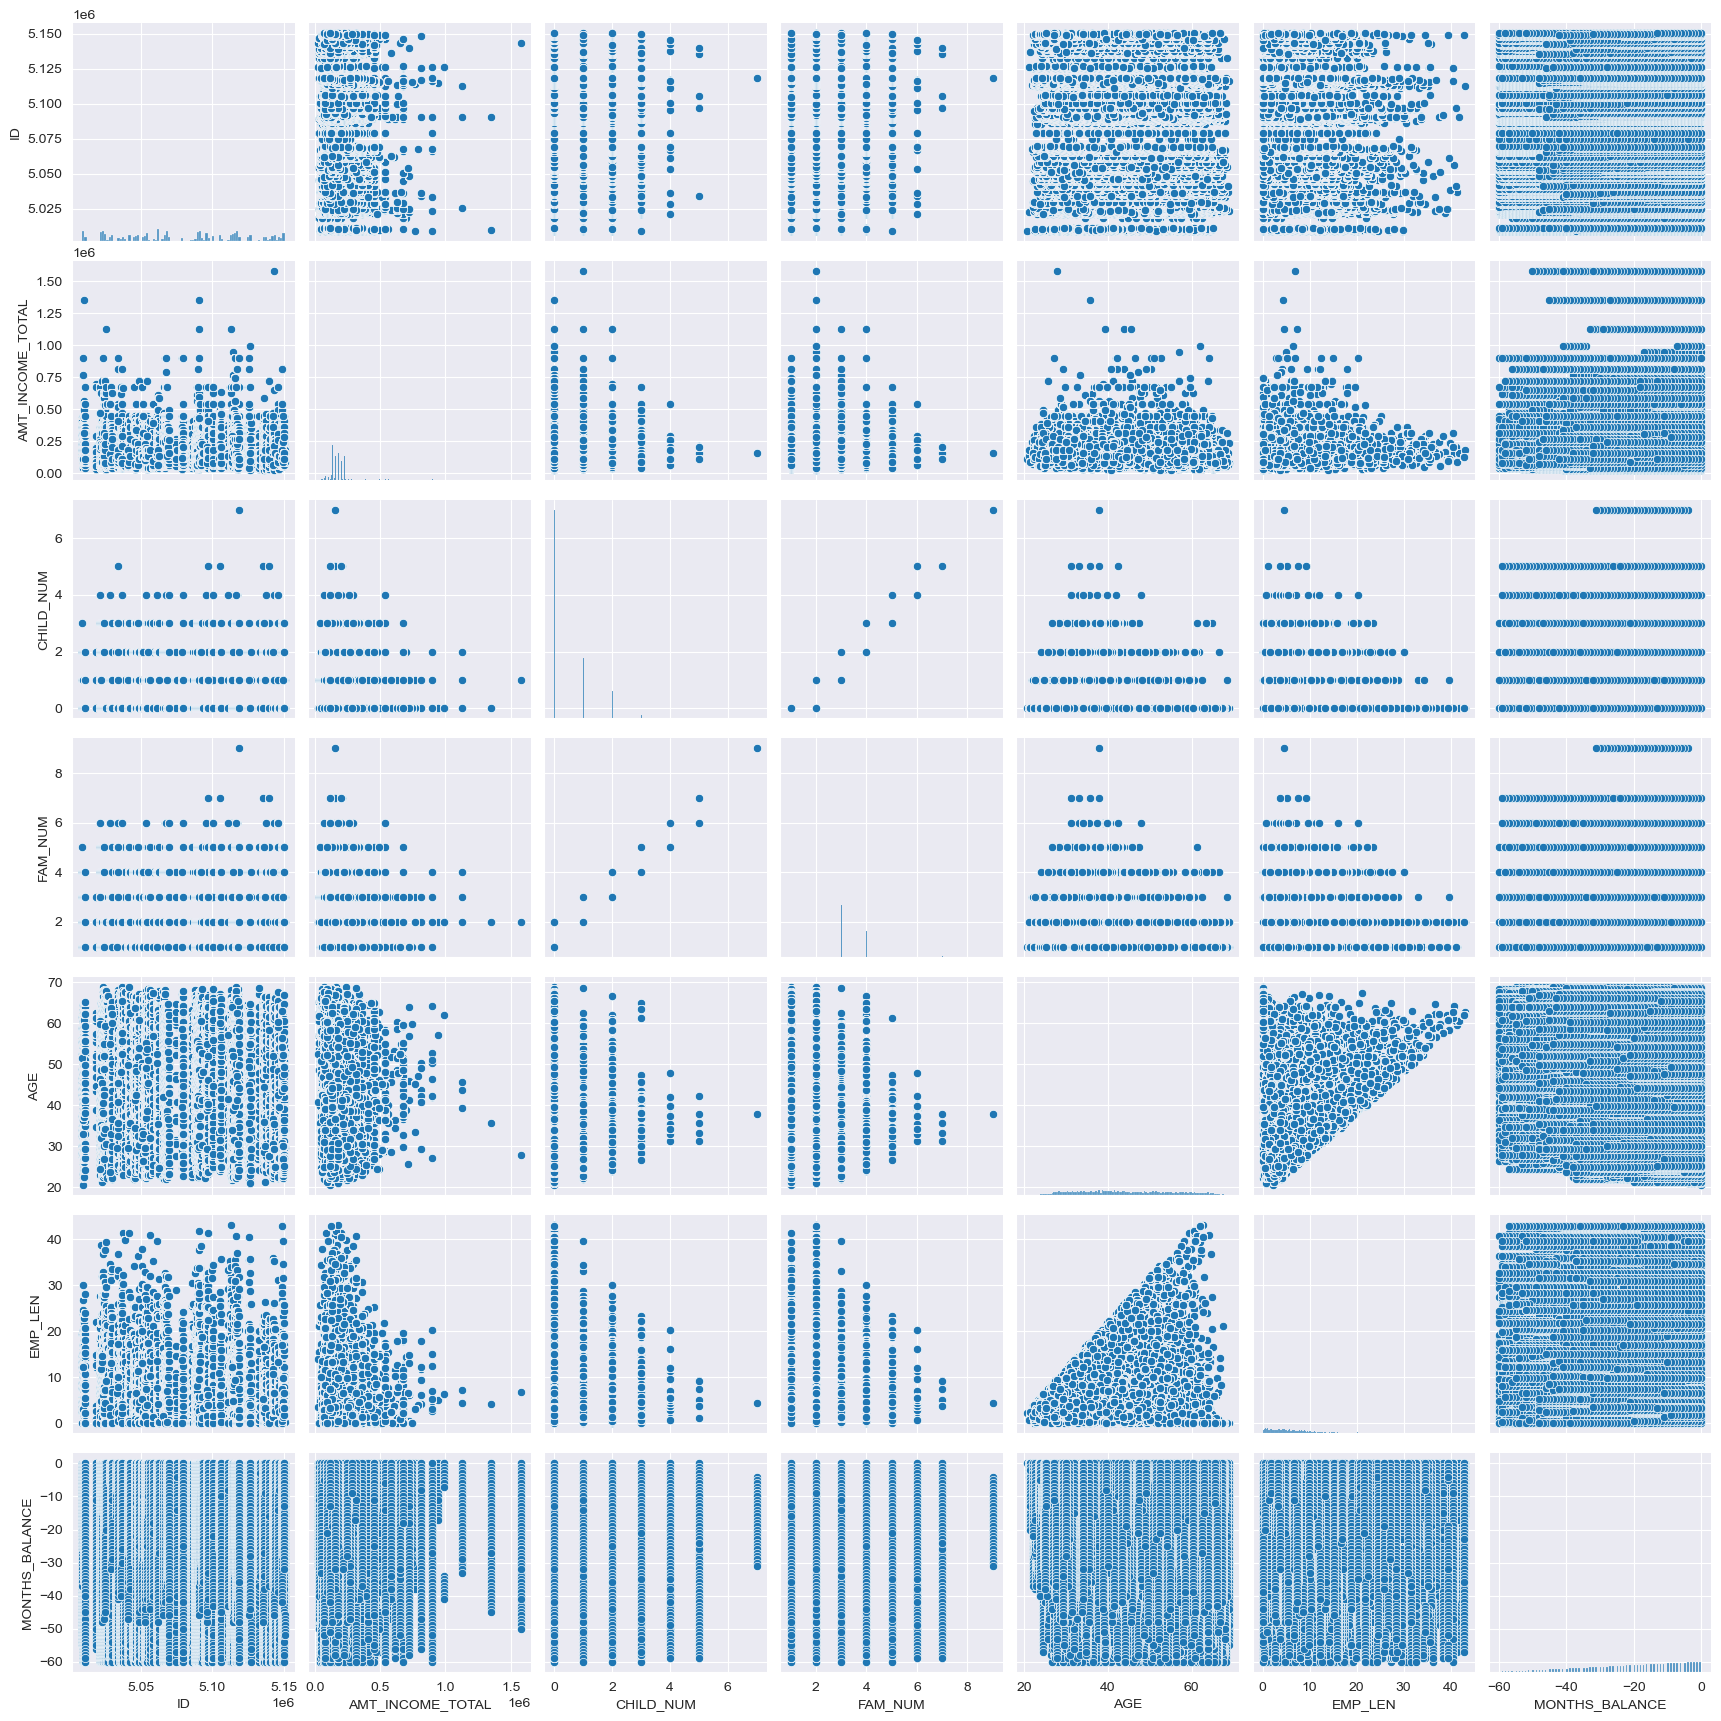

In [10]:
cred_num = credit.select_dtypes(['int32','int64','float64'])
sns.pairplot(cred_num)

data is mostly skewed(going to take it carefully during scaling

In [11]:
print(credit.skew())

ID                  0.073309
AMT_INCOME_TOTAL    2.577647
CAR_OWN             0.445504
REALTY_OWN         -0.673352
CHILD_NUM           1.751921
FAM_NUM             0.915244
AGE                 0.176683
EMP_LEN             1.692014
WORK_PHONE          1.270923
EMAIL               2.829568
IS_MALE             0.710365
MONTHS_BALANCE     -0.598672
dtype: float64


C:\Users\dimas\AppData\Local\Temp\ipykernel_21140\3078635942.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(credit.skew())


In [12]:
credit['STATUS'].unique()

array(['C', '1', '0', 'X', '5', '4', '3', '2'], dtype=object)

0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

In [13]:
stat_map={'C':'paid off','0':'0-1','1': '1-2','2':'2-3','3': '3-4','4': '4-5','5':'5+','X':'no loan'}
credit['STATUS']=credit['STATUS'].replace(stat_map).astype('category')
credit['ID']=credit['ID'].astype('category')

In [14]:
credit['STATUS'].unique()

['paid off', '1-2', '0-1', 'no loan', '5+', '4-5', '3-4', '2-3']
Categories (8, object): ['0-1', '1-2', '2-3', '3-4', '4-5', '5+', 'no loan', 'paid off']

dividing dataset into the risky(disapproval)and not risky(approval)part

In [15]:
def get_label(status):
    if status in ('5+', '4-5', '3-4', '2-3'):
        return 1 # Risky
    else:
        return 0 # Not risky

In [16]:
credit['RISK'] = credit['STATUS'].apply(get_label)
credit['RISK'] = credit['RISK'].astype('category')

In [17]:
print(len(credit.drop_duplicates()['ID']))

777342


figuring out distribution to check if the division was right(it was)

([<matplotlib.patches.Wedge at 0x16e3f6dc670>,
 [Text(-1.0999292699338512, 0.012474018710300865, ''),
  Text(1.099929270709409, -0.012473950323278818, '')])

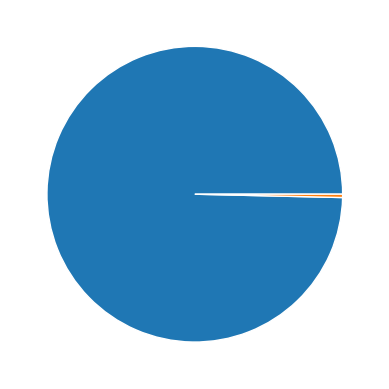

In [18]:
num_st = credit['RISK'].value_counts()
plt.pie(num_st)

<AxesSubplot:>

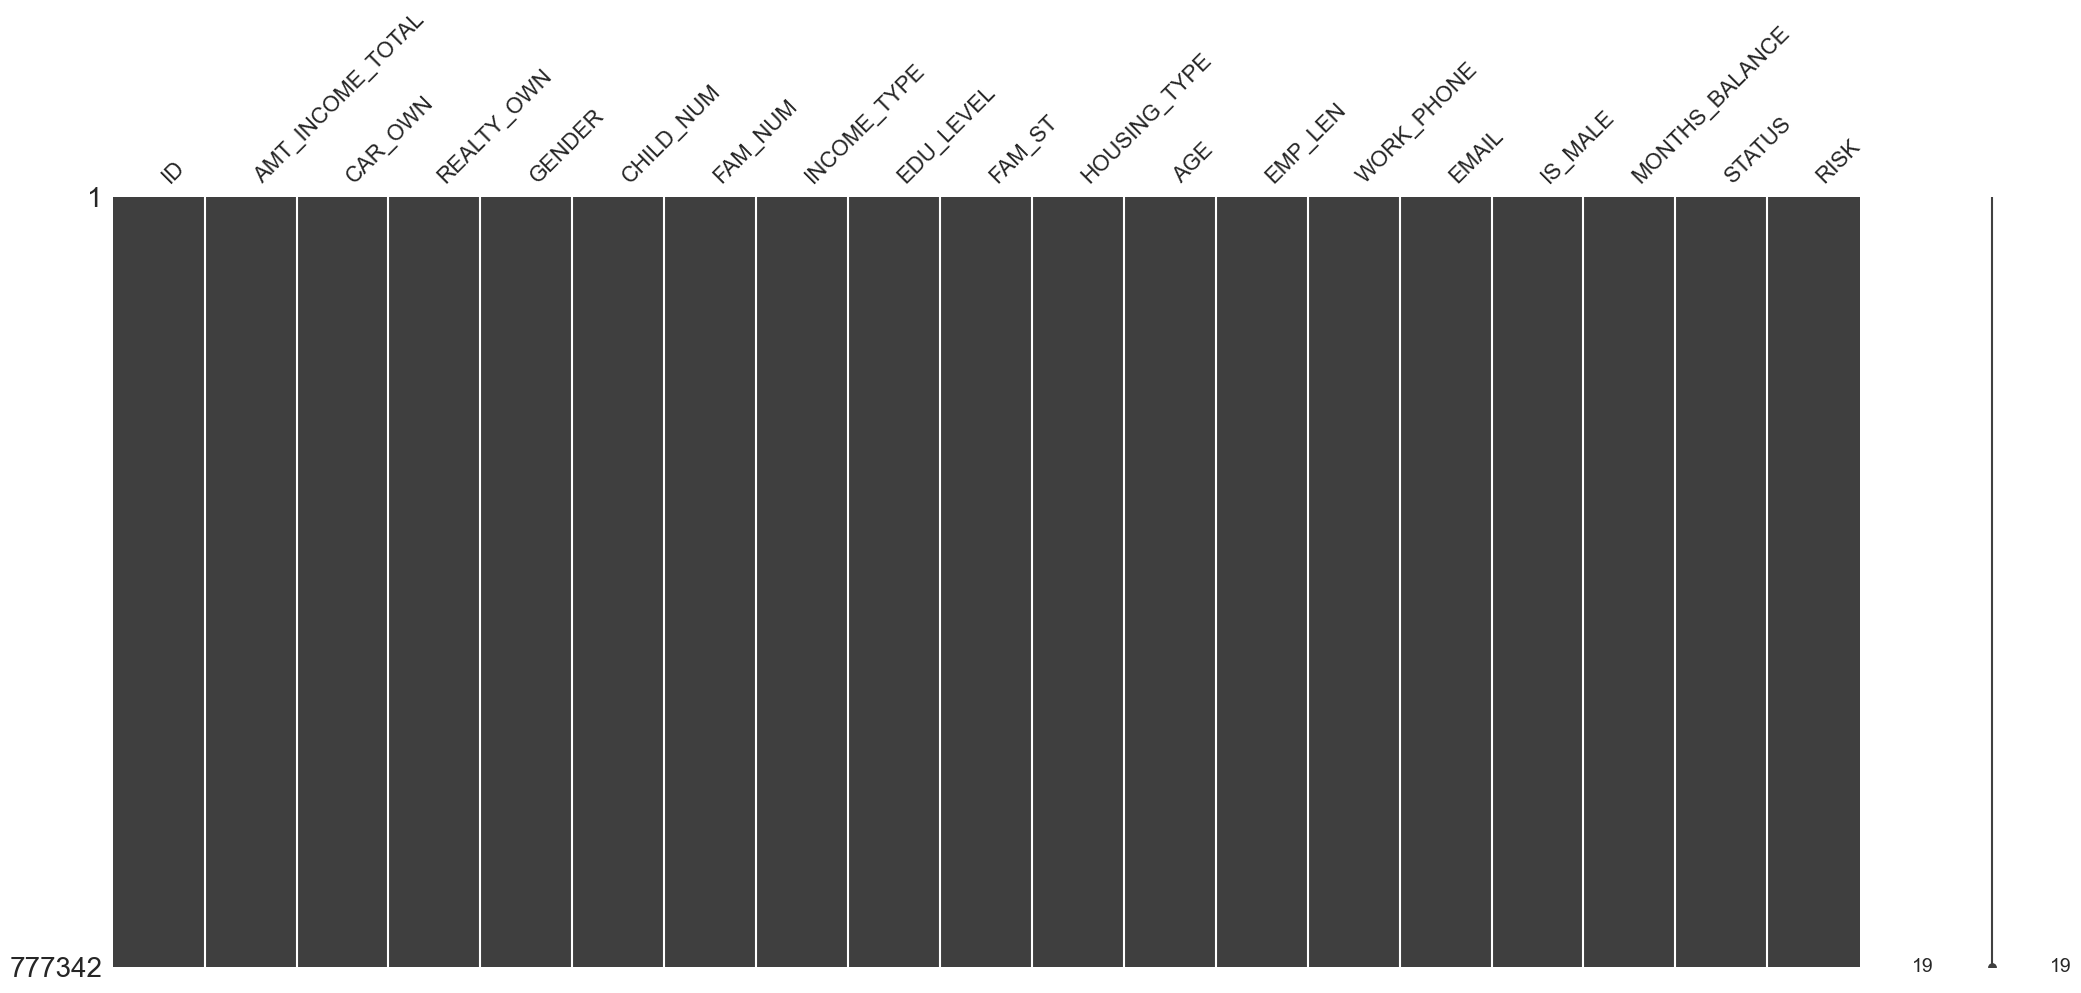

In [19]:
msno.matrix(credit)

In [20]:
credit = credit.dropna()

ordinal encoding(assuming that distances are equal and the level of education is main factor(instead ot years studying)

In [21]:
map_st = {'0-1': 1, '1-2': 2, '2-3': 3, '3-4': 4, '4-5': 5, '5+': 6, 'no loan': 0, 'paid off': 0}
credit['STATUS'] = credit['STATUS'].replace(map_st).astype('int')
map_edu = {'Lower secondary': 0, 'Secondary / secondary special': 1, 'Incomplete higher': 2, 'Higher education': 3,
           'Academic degree': 4}
credit['EDU_LEVEL'] = credit['EDU_LEVEL'].replace(map_edu).astype('int')

splitting data and getting it ready for scaling

In [22]:
credit=credit.sort_values('AGE')
cred_num_sc = credit.select_dtypes(['int32','int64','float64','int64']).sort_values('AGE')
cred_cat = credit.select_dtypes(['category','bool'])

scaling(robust scaling was chosen,for skewness being common

In [23]:
scaler = RobustScaler()
credit_num_sc = scaler.fit_transform(cred_num_sc)

completting data

In [24]:
credit_num_sc = pd.DataFrame(credit_num_sc,columns=cred_num_sc.columns)
credit = pd.concat([credit_num_sc,cred_cat],axis=1)
credit = credit.drop('ID',axis=1)

In [34]:
credit = credit.dropna()

one-hot encoding those columns,where there is no linearity found between categories(but they certainly have impact)

In [35]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoded = encoder.fit_transform(credit[['INCOME_TYPE','FAM_ST','HOUSING_TYPE']])
one_hot_cred = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names(['INCOME_TYPE','FAM_ST','HOUSING_TYPE']))
credit = pd.concat([credit, one_hot_cred], axis=1)

C:\Users\dimas\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


dropping old columns

In [36]:
credit = credit.drop(['INCOME_TYPE','FAM_ST','HOUSING_TYPE'],axis=1)

converting everything to numeric(in a purpose of resampling)During that,all the boolean values have been changed to the more computationally expensive float64

In [41]:
credit = credit.applymap(lambda x: pd.to_numeric(x, errors='coerce'))

In [45]:
credit.columns

Index(['AMT_INCOME_TOTAL', 'CHILD_NUM', 'FAM_NUM', 'EDU_LEVEL', 'AGE',
       'EMP_LEN', 'MONTHS_BALANCE', 'STATUS', 'CAR_OWN', 'REALTY_OWN',
       'GENDER', 'WORK_PHONE', 'EMAIL', 'IS_MALE', 'RISK',
       'INCOME_TYPE_Commercial associate', 'INCOME_TYPE_Pensioner',
       'INCOME_TYPE_State servant', 'INCOME_TYPE_Student',
       'INCOME_TYPE_Working', 'FAM_ST_Civil marriage', 'FAM_ST_Married',
       'FAM_ST_Separated', 'FAM_ST_Single / not married', 'FAM_ST_Widow',
       'HOUSING_TYPE_Co-op apartment', 'HOUSING_TYPE_House / apartment',
       'HOUSING_TYPE_Municipal apartment', 'HOUSING_TYPE_Office apartment',
       'HOUSING_TYPE_Rented apartment', 'HOUSING_TYPE_With parents',
       'INCOME_TYPE_Commercial associate', 'INCOME_TYPE_Pensioner',
       'INCOME_TYPE_State servant', 'INCOME_TYPE_Student',
       'INCOME_TYPE_Working', 'FAM_ST_Civil marriage', 'FAM_ST_Married',
       'FAM_ST_Separated', 'FAM_ST_Single / not married', 'FAM_ST_Widow',
       'HOUSING_TYPE_Co-op apartm

In [48]:
credit[['INCOME_TYPE_Commercial associate', 'INCOME_TYPE_Pensioner',
'INCOME_TYPE_State servant', 'INCOME_TYPE_Student',
'INCOME_TYPE_Working', 'FAM_ST_Civil marriage', 'FAM_ST_Married',
'FAM_ST_Separated', 'FAM_ST_Single / not married', 'FAM_ST_Widow',
'HOUSING_TYPE_Co-op apartment', 'HOUSING_TYPE_House / apartment',
'HOUSING_TYPE_Municipal apartment', 'HOUSING_TYPE_Office apartment',
'HOUSING_TYPE_Rented apartment', 'HOUSING_TYPE_With parents']] = credit[['INCOME_TYPE_Commercial associate', 'INCOME_TYPE_Pensioner',
      'INCOME_TYPE_State servant', 'INCOME_TYPE_Student',
      'INCOME_TYPE_Working', 'FAM_ST_Civil marriage', 'FAM_ST_Married',
      'FAM_ST_Separated', 'FAM_ST_Single / not married', 'FAM_ST_Widow',
      'HOUSING_TYPE_Co-op apartment', 'HOUSING_TYPE_House / apartment',
      'HOUSING_TYPE_Municipal apartment', 'HOUSING_TYPE_Office apartment',
      'HOUSING_TYPE_Rented apartment', 'HOUSING_TYPE_With parents']].astype('bool')

In [49]:
credit_sampled = credit.copy(deep=True)

In [50]:
credit_sampled = credit_sampled.dropna()

In [51]:
X = credit_sampled.drop("RISK", axis=1)
y = credit_sampled["RISK"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
tl = TomekLinks(sampling_strategy='majority')
X_resampled, y_resampled = tl.fit_resample(X_train, y_train)

In [79]:
rf_clf = RandomForestClassifier(n_estimators=10, random_state=42,min_samples_split=15)
rf_clf.fit(X_resampled, y_resampled)

RandomForestClassifier(min_samples_split=15, n_estimators=10, random_state=42)

In [80]:
y_prob_rf = rf_clf.predict_proba(X_test)
y_pred_rf = (y_prob_rf[:,1] > 0.9).astype(int)
confusion_matrix(y_test,y_pred_rf)

array([[154768,      0],
       [   540,     25]], dtype=int64)

In [113]:
print(abs(rf_clf.feature_importances_).round(2)/(abs(rf_clf.feature_importances_.sum()))*100,rf_clf.feature_importances_)

[ 9.  2.  2. 34.  9. 28.  4.  3.  3.  3.  2.] [0.09257575 0.01788421 0.02256169 0.33967435 0.09160943 0.28039217
 0.03717133 0.03213981 0.02958539 0.03182919 0.02457666]


applyinf feature selection based on random forest(as an algorythm with the best performance by now)

In [ ]:
sfm = SelectFromModel(rf_clf, threshold=0.03, prefit=True)
X_train_sel = sfm.transform(X_resampled)
X_test_sel = sfm.transform(X_test)

In [106]:
rf_clf.fit(X_train_sel, y_resampled)
y_prob_rf_sel = rf_clf.predict_proba(X_test_sel)
y_pred_rf_sel = (y_prob_rf[:, 1] > 0.9).astype(int)
confusion_matrix(y_test, y_pred_rf_sel)

array([[154768,      0],
       [   540,     25]], dtype=int64)

In [114]:
filename_rf = 'rf_clf.joblib'
dump(rf_clf,filename=filename_rf)

['rf_clf.joblib']

In [110]:
knn = KNeighborsClassifier(n_neighbors=11, p=2)
knn.fit(X_train_sel, y_resampled)

KNeighborsClassifier(n_neighbors=11)

In [111]:
y_prob_knn = knn.predict_proba(X_test_sel)
y_pred_knn = (y_prob_knn[:,1] > 0.9).astype(int)
confusion_matrix(y_test, y_pred_knn)

array([[154768,      0],
       [   563,      2]], dtype=int64)

In [112]:
filename_knn = 'knn.joblib'
dump(knn,filename=filename_knn)

['knn.joblib']

logistic regression(all messed up,added just as an assertation of data complexity level)

In [134]:
lg = LogisticRegression(random_state=42)
lg.fit(X_train_sel, y_resampled)
y_prob_lg = lg.predict_proba(X_test_sel)
y_pred_lg = (y_prob_lg[:,1] > 0.08).astype(int)
confusion_matrix(y_test, y_pred_lg)

array([[154768,      0],
       [   565,      0]], dtype=int64)

In [135]:
filename_lg = 'lg.joblib'
dump(lg,filename=filename_lg)

['lg.joblib']